# ModelV2
## Object detection non-overlapping cards

In [1]:
!pip -q install ultralytics wandb


In [2]:
from ultralytics import YOLO
from jassair.utils.paths import get_dataset_path, Datasets
import wandb
import time
import torch
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

%matplotlib inline

### Global variable definition

In [3]:
# DATA_DIR = get_dataset_path(Datasets.SWISS)
BATCH_SIZE = 16
NUM_CLASSES = 36

In [4]:
torch.cuda.is_available()

True

Enable W&B logging for Ultralytics in CLI

`yolo settings wandb=True`

Disable Weights & Biases logging

`yolo settings wandb=False`

In [5]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aarfu (aarfu-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Model
We can use a singel YOLO model for both, object detection and classification tasks.

In [19]:
MODEL = YOLO("yolo11l.pt") # YOLOv11 large

## Train
imgsz: yolo resizes the input images to a square image. Since jasscards are not square, yolo resizes the long side to 640 and then scales the shorter side proportionally.

In [20]:
# Hyperparameters

HYPERPARAMETERS = {
    "lr0": 1e-4,
    "weight_decay": 1e-4,
    "imgsz": 640,
    "epochs": 100,
}

AUGMENTATION = {
    "degrees": 10,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 2.0,
    "perspective": 0.001,
    "flipud": 0.1,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
}

In [10]:
RUN_NAME = f"yolo11l_srf_1to9_36c_movlp_2_{time.strftime('%y%m%d-%H%M%S')}"

In [22]:
wandb.init(
    entity="jassair",
    project="ModelV2",  # Specify project
    name=RUN_NAME, # Run name
    config=HYPERPARAMETERS,
)

In [23]:
MODEL.train(
    data="/exchange/dspro2/jassair/srf_1to9_36c_movlp/data.yaml",
    device=0,
    batch=BATCH_SIZE,
    optimizer="Adam",
    momentum=0.937,
    project="jassair",
    name=RUN_NAME,
    patience=10,
    **HYPERPARAMETERS,
    **AUGMENTATION
)


Ultralytics 8.3.128 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/exchange/dspro2/jassair/srf_1to9_36c_movlp/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11l_srf_1to9_36c_movlp_2_250507-183928, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, pa

train: Scanning /exchange/dspro2/jassair/srf_1to9_36c_movlp/train/labels.cache... 1032 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1032/1032 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 787.8±372.3 MB/s, size: 644.5 KB)


val: Scanning /exchange/dspro2/jassair/srf_1to9_36c_movlp/valid/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]


Plotting labels to jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0001), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.1G      1.099      3.113      1.356         62        640: 100%|██████████| 65/65 [01:09<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        132        510      0.331      0.391      0.257      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      10.3G       1.05      1.774      1.269         68        640: 100%|██████████| 65/65 [01:08<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.595      0.724      0.722      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.3G     0.9681      1.253      1.229         63        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.783       0.85      0.889      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.2G     0.9588      1.078      1.223         59        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.839      0.913      0.933      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      10.4G     0.9276     0.9588      1.203         77        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510       0.85      0.927      0.927      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      10.3G     0.8679     0.9105      1.176         68        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.881      0.888      0.937      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.3G     0.8445     0.8299       1.16         81        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.912      0.916      0.946      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.2G     0.8148     0.7886      1.154         57        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.922      0.933      0.959      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.3G     0.7971     0.7744      1.137         74        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.943      0.941      0.969      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.3G     0.7747     0.7225      1.128        100        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.957       0.95      0.971      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.4G     0.7779      0.723      1.135         75        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.956      0.952      0.974      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.2G     0.7592     0.7012      1.116         64        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.939      0.947      0.969      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      10.3G     0.7489     0.6911      1.108         65        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.943      0.946       0.97      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.3G     0.7268     0.6511      1.094         39        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.961      0.939      0.972       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.3G     0.7272     0.6591      1.102         75        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.958       0.93      0.974      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.2G     0.7158      0.647      1.097         77        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.969      0.944       0.97      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.3G     0.7035     0.6304      1.088         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.956      0.953      0.973      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.3G     0.7205      0.621      1.097         74        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510       0.97      0.946       0.98      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.4G     0.6833     0.5973      1.088         57        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.972      0.947      0.974      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.2G     0.6722     0.5942      1.077         65        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.963      0.946      0.974      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.3G     0.6729     0.5847      1.079         71        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.971      0.955      0.977      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.3G     0.6702     0.5926      1.077         50        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.976      0.952      0.979      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.3G     0.6527     0.5752      1.069         58        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.957      0.949      0.973      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.3G     0.6559     0.5652      1.073         70        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.955      0.949       0.97      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.3G     0.6473     0.5562      1.065         67        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.962      0.952      0.971      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.4G     0.6217     0.5389       1.06         52        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.965      0.956      0.975      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.3G      0.621      0.539      1.058         83        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.971      0.963      0.977      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.3G      0.628     0.5364      1.051         69        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.968      0.949      0.973      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.3G      0.617     0.5308      1.051         89        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.963      0.952      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      10.3G     0.6093     0.5311      1.042         61        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.978      0.952      0.972      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.4G     0.6067     0.5241      1.052         64        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.976      0.946      0.973      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.2G     0.5863     0.5199      1.037         70        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.955      0.967      0.976      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.4G     0.5982     0.5173      1.043        105        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.976       0.95      0.977      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.3G     0.5844     0.5099      1.041         57        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.973      0.956      0.977      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.3G     0.5982     0.5126      1.036         58        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.975      0.959      0.974      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.3G     0.5765     0.4853      1.029         58        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.977      0.963      0.976      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.4G     0.5757     0.4933      1.031         61        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.975      0.965      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.3G     0.5841      0.487      1.034         77        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.969      0.959      0.971      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.3G     0.5733     0.4759      1.029         46        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.966      0.957      0.968      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.3G     0.5738     0.4757      1.024         69        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510       0.97      0.955      0.975      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      10.3G     0.5512     0.4709      1.016         58        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.971       0.96      0.976      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      10.3G      0.555     0.4751      1.026         69        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.975      0.961      0.977      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.3G      0.568     0.4731      1.021         52        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510       0.98      0.965      0.978       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.3G     0.5493     0.4683      1.014         63        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.974      0.963      0.977      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.3G     0.5394     0.4407      1.012         29        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.976      0.962      0.976      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.3G     0.5313     0.4424      1.006         44        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.976      0.958      0.971      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.4G     0.5394     0.4478      1.012         50        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.965      0.967      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.2G     0.5321     0.4374      1.002         54        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.975      0.967      0.974      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      10.3G     0.5331     0.4514      1.005         77        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.974      0.964      0.974      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.3G     0.5369     0.4491       1.01         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.977      0.968      0.976      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.3G     0.5234     0.4338      1.002         71        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.976      0.966      0.979      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      10.2G     0.5333     0.4413      1.008         50        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.977      0.963      0.979      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.4G     0.5186     0.4297     0.9978         58        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510       0.98      0.957      0.978      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.3G     0.5216     0.4177     0.9989         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.971      0.964      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.3G     0.5117     0.4253     0.9945         83        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.975      0.966      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      10.3G     0.5098     0.4273      0.993         92        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.974      0.967      0.978      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.3G     0.5026     0.4198     0.9921         75        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510       0.98      0.965      0.979      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.3G     0.5011      0.421     0.9881         72        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.973       0.97      0.978      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.3G      0.508     0.4262     0.9912         78        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.972      0.971       0.98      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.2G     0.5065     0.4124     0.9877         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.976      0.974      0.984      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.3G      0.501     0.4084     0.9877         62        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.978      0.969      0.979      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.4G     0.4781     0.3919     0.9779         50        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.974      0.972      0.979      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.3G     0.4904     0.3985     0.9829         99        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.978      0.966      0.982      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.3G     0.4822     0.3857     0.9767         83        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.977       0.97      0.981      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.4G     0.4817      0.398     0.9748         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.977       0.97       0.98       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.3G     0.4743     0.3919     0.9812         52        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.976      0.968      0.982      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.3G     0.4803     0.3911     0.9808         54        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.978      0.969      0.979      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.3G     0.4846     0.3941     0.9752         47        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.979      0.969       0.98       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.3G     0.4819     0.3947     0.9781         83        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.979      0.972       0.98      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.3G     0.4775     0.3896     0.9703         82        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.982      0.974      0.984      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.4G     0.4639      0.385     0.9683         71        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.982      0.972      0.983      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.3G     0.4693     0.3879      0.973         63        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.987      0.974      0.982      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.3G     0.4552     0.3875      0.966         55        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.982      0.975      0.981      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.3G     0.4636     0.3882      0.967         88        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.977      0.971      0.978      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.3G     0.4627     0.3847     0.9661         75        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.981      0.972      0.983      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.3G     0.4571     0.3717     0.9615         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.981      0.969      0.983       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.3G     0.4465     0.3649     0.9584         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.977      0.971      0.984      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.3G     0.4499     0.3687     0.9568         76        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.981      0.974      0.984      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.3G     0.4514     0.3804     0.9601         72        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        132        510      0.979      0.974      0.983      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.2G     0.4513     0.3676     0.9641         32        640: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        132        510      0.976      0.973      0.981      0.964
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 70, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



80 epochs completed in 1.619 hours.
Optimizer stripped from jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928/weights/last.pt, 51.3MB
Optimizer stripped from jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928/weights/best.pt, 51.3MB

Validating jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
YOLO11l summary (fused): 190 layers, 25,307,068 parameters, 0 gradients, 86.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


                   all        132        510      0.982      0.974      0.984      0.966
             eichel 10         14         14      0.994          1      0.995      0.955
              eichel 6         11         11       0.91          1      0.995      0.986
              eichel 7         13         13      0.995      0.846      0.886      0.886
              eichel 8         11         11      0.948          1      0.995      0.986
              eichel 9         13         13      0.923          1      0.968      0.956
            eichel ass         15         15      0.994          1      0.995      0.989
          eichel konig         14         14      0.996          1      0.995       0.95
           eichel ober         13         13      0.994          1      0.995      0.967
          eichel under         12         12      0.993          1      0.995      0.978
               rose 10         14         14      0.932          1      0.934      0.918
                rose 

lr/pg0,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▂███▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
lr/pg2,▂████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▇██████████████████████████████████████
metrics/mAP50-95(B),▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇██▇██▇███████▇███
metrics/precision(B),▁▄▆▆▇███████████████████████████████████
metrics/recall(B),▁▅▅▃▅▇▇▆▆▆▆▆▇▇▇▇█▇▇▇▇▇█▇█▇██▇███████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f99eef0ef60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0380

In [7]:
wandb.finish()

In [9]:
run = wandb.init(
    entity="jassair",
    project="ModelV2",
    name="upload-final-yolov11-model-srf-data"
)

model_path = "jassair/yolo11l_srf_1to9_36c_movlp_250505-152928/weights/best.pt"

artifact = wandb.Artifact(
    name="upload-final-yolov11-model-srf-data",
    type="model",
    description="YOLOv11 model trained on mix of synthetic and real life images, 1to9, 36c, overlapping and non overlapping cards. Real life images from srf",
    metadata={"framework": "Ultralytics YOLO", "version": "v11"}
)

artifact.add_file(model_path)
run.log_artifact(artifact)

run.finish()

## Finetune on real life images

In [6]:
model = YOLO("jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928Finetuned/weights/best.pt")

In [7]:
# Freeze backbone layers in the Sequential model
for i, (name, module) in enumerate(model.model.model.named_children()):
    if i <= 8:
        for param in module.parameters():
            param.requires_grad = False

In [8]:
epochs = 50
batch_size = 16

HYPERPARAMETERS = {
    "lr0": 1e-4,
    "weight_decay": 1e-5,
    "imgsz": 640,
    "epochs": 20,
}

AUGMENTATION = {
    "degrees": 5,
    "translate": 0.05,
    "scale": 0.2,
    "shear": 1.0,
    "perspective": 0.001,
    "flipud": 0.0,
    "hsv_h": 0.01,
    "hsv_s": 0.5,
    "hsv_v": 0.3,
}

In [11]:
wandb.init(
    entity="jassair",
    project="ModelV2",
    name=RUN_NAME + '2xFinetuned',
    config=HYPERPARAMETERS,
)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aarfu (aarfu-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
# Model with all tunable hyperparameters
model.train(
    data='/exchange/dspro2/jassair/r_1to9_36c_novlp2/data.yaml',
    device=0,
    batch=BATCH_SIZE,
    optimizer="Adam",
    momentum=0.937,
    project="jassair",
    name=RUN_NAME + 'Finetuned',
    patience=10,
    **HYPERPARAMETERS,
    **AUGMENTATION
)

Ultralytics 8.3.128 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/exchange/dspro2/jassair/r_1to9_36c_novlp2/data.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=jassair/yolo11l_srf_1to9_36c_movlp_2_250507-183928Finetuned/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned, nbs=64, nms=Fa

train: Scanning /exchange/dspro2/jassair/r_1to9_36c_novlp2/train/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1263.02it/s]

train: New cache created: /exchange/dspro2/jassair/r_1to9_36c_novlp2/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 6, len(boxes) = 75. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1326.3±489.2 MB/s, size: 1988.4 KB)


val: Scanning /exchange/dspro2/jassair/r_1to9_36c_novlp2/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 197.76it/s]

val: New cache created: /exchange/dspro2/jassair/r_1to9_36c_novlp2/valid/labels.cache


Plotting labels to jassair/yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=1e-05), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to jassair/yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.95G     0.8341      1.031      1.265         28        640: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          5         21      0.719      0.824      0.878       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20        10G     0.8101      1.039      1.294         34        640: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          5         21      0.763      0.765      0.893      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.1G     0.7654      1.313      1.291         24        640: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all          5         21      0.625      0.882      0.868      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.1G     0.8444      1.656      1.345         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all          5         21      0.565      0.636      0.748      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.2G      0.695     0.9779      1.193         32        640: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all          5         21      0.709      0.581      0.661      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.2G     0.7631     0.9574       1.25         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all          5         21      0.747      0.588      0.646      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.2G     0.8043      1.003      1.292         34        640: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all          5         21      0.544      0.588      0.693      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.1G     0.6955     0.9908      1.208         26        640: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all          5         21      0.874      0.465      0.717      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.1G     0.6409     0.9609      1.173         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all          5         21      0.731       0.51       0.79      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.2G     0.7162     0.8153      1.154         24        640: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all          5         21      0.732      0.526      0.805      0.544


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.2G     0.4786     0.5328     0.9958         16        640: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all          5         21      0.775      0.529      0.878      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.2G     0.4715     0.4989      1.005         15        640: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all          5         21      0.629      0.647      0.878      0.623
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



12 epochs completed in 0.010 hours.
Optimizer stripped from jassair/yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned/weights/last.pt, 51.2MB
Optimizer stripped from jassair/yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned/weights/best.pt, 51.2MB

Validating jassair/yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
YOLO11l summary (fused): 190 layers, 25,307,068 parameters, 0 gradients, 86.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


                   all          5         21       0.76      0.765      0.893      0.803
             Eichel 10          2          2      0.797          1      0.995      0.796
              Eichel 9          1          1          1          1      0.995      0.895
                Rose 8          2          2        0.7          1      0.995      0.995
                Rose 9          1          1          1          0      0.995      0.895
              Rose Ass          1          1      0.589          1      0.995      0.895
            Rose Konig          1          1       0.46          1      0.995      0.995
             Rose Ober          2          2      0.584          1      0.995      0.895
           Schelle Ass          2          2          1          1      0.995      0.958
         Schelle Konig          1          1      0.897          1      0.995      0.597
          Schelle Ober          1          1      0.715          1      0.995      0.895
           Schilten 1

lr/pg0,█▇▇▆▅▅▄▄▃▂▂▁
lr/pg1,▁▂▄▅▆▆▇▇████
lr/pg2,▁▂▄▅▆▆▇▇████
metrics/mAP50(B),██▇▄▁▁▂▃▅▆██
metrics/mAP50-95(B),▇█▇▄▃▂▂▁▂▂▄█
metrics/precision(B),▅▆▃▁▄▅▁█▅▅▆▆
metrics/recall(B),▇▆█▄▃▃▃▁▂▂▂▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇█▅▆▇▅▄▆▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  4, 12, 13, 14, 15, 16, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fcb6904f6b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.04

In [94]:
wandb.finish()

In [ ]:
run = wandb.init(
    entity="jassair",
    project="ModelV2",
    name="upload-final-finetuned-yolov11-model"
)

model_path = "jassair/yolo11l_s_1to9_36c_novlp_250423-181626Finetuned/weights/best.pt"

artifact = wandb.Artifact(
    name="yolov11-finetuned-model-non-overlapping",
    type="model",
    description="YOLOv11 model trained on real world, 3to5, 36c, non overlapping cards",
    metadata={"framework": "Ultralytics YOLO", "version": "v11"}
)

artifact.add_file(model_path)
run.log_artifact(artifact)

run.finish()

## Test Evaluation

In [13]:
# Load best model
model_path = "jassair/yolo11l_srf_1to9_36c_movlp_2_250508-072129Finetuned/weights/best.pt"

model = YOLO(model_path)

In [14]:
# Function for random selecting an image from a defined path

def random_test_image(pad_to_square=True):
    test_path = Path("/exchange/dspro2/jassair/r_1to9_36c_novlp/test/images")
    
    image_files = list(test_path.glob("*.png")) + list(test_path.glob("*.jpg"))
    random_image_path = random.choice(image_files)

    image = Image.open(random_image_path)

    # Convert to RGB if needed
    if image.mode in ("RGBA", "P"):
        image = image.convert("RGB")

    # Resize longest side to 640 while keeping aspect ratio
    width, height = image.size
    scale = 640 / max(width, height)
    new_size = (int(width * scale), int(height * scale))
    image = image.resize(new_size, Image.Resampling.LANCZOS)

    if pad_to_square:
        delta_w = 640 - image.size[0]
        delta_h = 640 - image.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        image = ImageOps.expand(image, padding, fill=(114, 114, 114))

    return image



In [11]:
# Function to load one image from path with image number
def one_test_image(img_path, num, pad_to_square=True):
    test_path = Path(img_path)
    img_files = list(test_path.glob("*.png")) + list(test_path.glob("*.jpg"))

    img = Image.open(img_files[num])

    # Convert to RGB if needed
    if img.mode in ("RGBA", "P"):
        img = img.convert("RGB")

    # Resize longest side to 640 while keeping aspect ratio
    width, height = img.size
    scale = 640 / max(width, height)
    new_size = (int(width * scale), int(height * scale))
    img = img.resize(new_size, Image.Resampling.LANCZOS)

    if pad_to_square:
        delta_w = 640 - img.size[0]
        delta_h = 640 - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=(114, 114, 114))

    return img


In [12]:
# Function to display an image with mathplotlib

def display_img(img, size):
    plt.figure(figsize=(size, size))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

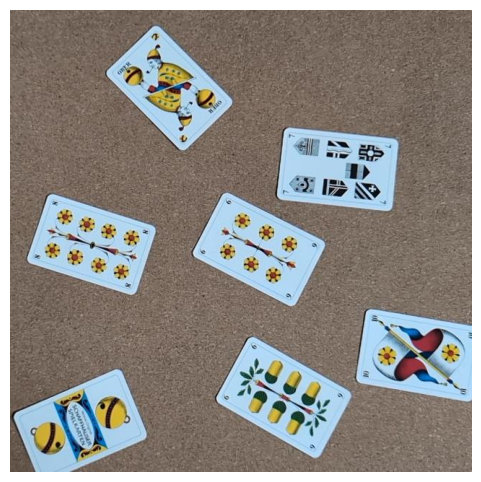

In [13]:
# Load a random test image and display it
test_image = random_test_image()
display_img(test_image, 6)

In [14]:
# Function for making a detection and classification with the loaded model
# conf = confidence threshold
def classify(model, conf, img):
    results = model(img, conf=conf)
    display_img(results[0].plot(), 6)


0: 640x640 1 Eichel 6, 1 Rose 10, 1 Rose 6, 1 Rose 8, 1 Schelle Ass, 1 Schelle Ober, 1 Schilte 7, 1 Schilte 8, 7.1ms
Speed: 3.9ms preprocess, 7.1ms inference, 411.0ms postprocess per image at shape (1, 3, 640, 640)


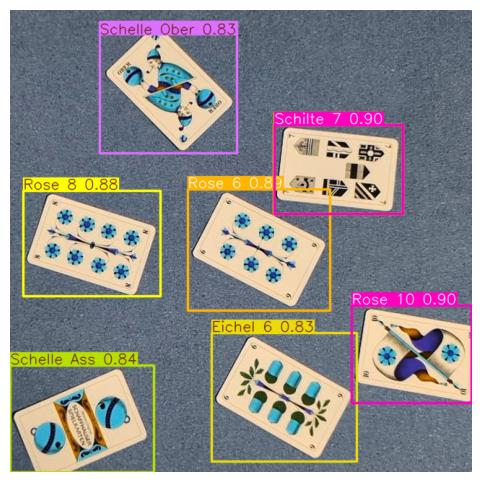

In [15]:
classify(model, 0.1, test_image)

### Automatic Evaluation on Testset

In [15]:
model.val(data="/exchange/dspro2/jassair/r_1to9_36c_novlp2/data.yaml", split='test')

Ultralytics 8.3.128 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
YOLO11l summary (fused): 190 layers, 25,307,068 parameters, 0 gradients, 86.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3324.1±458.8 MB/s, size: 1920.5 KB)


val: Scanning /exchange/dspro2/jassair/r_1to9_36c_novlp2/test/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


                   all         74        301      0.784      0.735      0.858      0.779
             Eichel 10          7          7          1      0.799      0.995      0.906
              Eichel 6          9          9      0.709      0.667      0.756      0.675
              Eichel 7          7          7      0.705      0.429      0.787      0.728
              Eichel 8          9          9      0.481      0.928      0.766      0.704
              Eichel 9          9          9          1      0.193       0.72      0.654
            Eichel Ass          7          7          1          1      0.995       0.94
          Eichel Konig         10         10      0.448        0.9      0.906       0.83
           Eichel Ober          9          9      0.839      0.581      0.831      0.754
          Eichel Under          8          8          1      0.857      0.949      0.863
               Rose 10         10         10      0.624        0.9      0.865      0.787
                Rose 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fcc802d7710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0380

In [18]:
print(model.ckpt_path)


jassair/yolo11l_s_1to9_36c_novlp_250423-181626Finetuned/weights/best.pt
